https://colab.research.google.com/drive/1gvKwGnlQJc4A6ZBQz1tZPLKNDct_T1Y8?usp=sharing

# Dropout Regularization in Deep Neural Network

This is a dataset that describes sonar chirp returns bouncing off different services. The 60 input variables are the strength of the returns at different angles. It is a **binary classification problem** that requires a model to differentiate rocks from metal cylinders.

Dataset information: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)
Download it from here: https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data

In [67]:
from personnal_utils import gpu_activation
gpu_activation()

In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn
from matplotlib import pyplot as plt

%matplotlib inline

In [69]:
# helps to filter warnings

import warnings
warnings.filterwarnings('ignore')

In [70]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"

sonar = pd.read_csv(url, names=["col_"+ str(i) for i in list(range(61))])
sonar.sample(5) # random sample

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60
172,0.0180,0.0444,0.0476,0.0698,0.1615,0.0887,0.0596,0.1071,0.3175,0.2918,...,0.0122,0.0114,0.0098,0.0027,0.0025,0.0026,0.0050,0.0073,0.0022,M
152,0.0131,0.0201,0.0045,0.0217,0.0230,0.0481,0.0742,0.0333,0.1369,0.2079,...,0.0168,0.0086,0.0045,0.0062,0.0065,0.0030,0.0066,0.0029,0.0053,M
151,0.0231,0.0315,0.0170,0.0226,0.0410,0.0116,0.0223,0.0805,0.2365,0.2461,...,0.0125,0.0036,0.0123,0.0043,0.0114,0.0052,0.0091,0.0008,0.0092,M
178,0.0197,0.0394,0.0384,0.0076,0.0251,0.0629,0.0747,0.0578,0.1357,0.1695,...,0.0134,0.0097,0.0042,0.0058,0.0072,0.0041,0.0045,0.0047,0.0054,M
35,0.0206,0.0132,0.0533,0.0569,0.0647,0.1432,0.1344,0.2041,0.1571,0.1573,...,0.0386,0.0147,0.0018,0.0100,0.0096,0.0077,0.0180,0.0109,0.0070,R


In [71]:
sonar.shape

(208, 61)

## mini EDA

<Axes: >

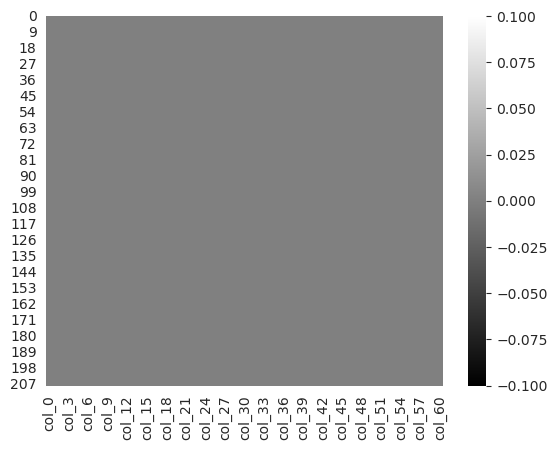

In [72]:
# MIssing VAlue

seaborn.heatmap(sonar.isna(), cmap="gray")

In [73]:
sonar.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14',
       'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21',
       'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28',
       'col_29', 'col_30', 'col_31', 'col_32', 'col_33', 'col_34', 'col_35',
       'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41', 'col_42',
       'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48', 'col_49',
       'col_50', 'col_51', 'col_52', 'col_53', 'col_54', 'col_55', 'col_56',
       'col_57', 'col_58', 'col_59', 'col_60'],
      dtype='object')

<Axes: xlabel='col_60'>

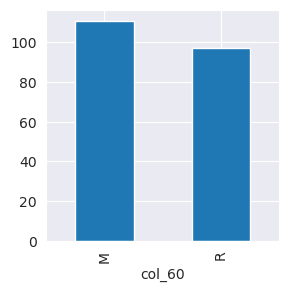

In [74]:
sonar.head(1)
# We know that our target is in the last column ==> we could just watch the unique values and their frequencies
plt.figure(figsize=(3,3))
sonar['col_60'].value_counts().plot(kind='bar')


### Separate the Features from target

In [75]:
X = sonar.drop('col_60', axis=1)
y = sonar.col_60

y.head()

0    R
1    R
2    R
3    R
4    R
Name: col_60, dtype: object

In [76]:
y = pd.get_dummies(y, drop_first=True)
y.sample(4)

,R
68,True
148,False
134,False
10,True


In [77]:
y.value_counts()

R    
False    111
True      97
Name: count, dtype: int64

In [78]:
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


### Splitting data

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [80]:
X_train.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59
67,0.0368,0.0403,0.0317,0.0293,0.0820,0.1342,0.1161,0.0663,0.0155,0.0506,...,0.0058,0.0091,0.0160,0.0160,0.0081,0.0070,0.0135,0.0067,0.0078,0.0068
14,0.0124,0.0433,0.0604,0.0449,0.0597,0.0355,0.0531,0.0343,0.1052,0.2120,...,0.0078,0.0083,0.0057,0.0174,0.0188,0.0054,0.0114,0.0196,0.0147,0.0062
164,0.0163,0.0198,0.0202,0.0386,0.0752,0.1444,0.1487,0.1484,0.2442,0.2822,...,0.0027,0.0077,0.0026,0.0031,0.0083,0.0020,0.0084,0.0108,0.0083,0.0033


### Using Deep learning Model
*Without the Dropout Layer*

In [81]:
# Architecture of my model

model_no_drop = keras.Sequential(
    [
        keras.layers.Dense(60, input_dim=60, activation='relu'),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)


model_no_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_no_drop.fit(X_train, y_train, epochs=100, batch_size=8)

Epoch 1/100
20/20 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5192
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6765 - accuracy: 0.6859
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.6090
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.7051
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.7372
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5829 - accuracy: 0.7564
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5530 - accuracy: 0.7692
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5119 - accuracy: 0.7949
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4946 - accuracy: 0.7564
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4557 - accuracy: 0.8654
Epoch 11/

In [82]:
model_no_drop.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.8254 - accuracy: 0.8077


[0.8253851532936096, 0.807692289352417]

On voit que l'accuracy sur le set de test n'est pas top, du à l'overfitting

Training Accuracy is > higher than Test Accuracy

In [83]:
y_pred = model_no_drop.predict(X_test).reshape(-1)
print(f'old y_pred: \n {y_pred[:5]}')
y_pred = np.round(y_pred) # round makes our prediction close to his original form which is or 0 or 1
print("------------\nnew y_pred:")
y_pred

2/2 [==============================] - 0s 2ms/step
old y_pred: 
 [1.7295682e-05 9.4582534e-01 9.9990821e-01 2.8331068e-04 1.0000000e+00]
------------
new y_pred:


array([0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0.], dtype=float32)

In [84]:
y_test[:5]

,R
186,False
155,False
165,False
200,False
58,True


In [85]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.93      0.83        27
        True       0.89      0.68      0.77        25

    accuracy                           0.81        52
   macro avg       0.83      0.80      0.80        52
weighted avg       0.82      0.81      0.80        52


<Axes: >

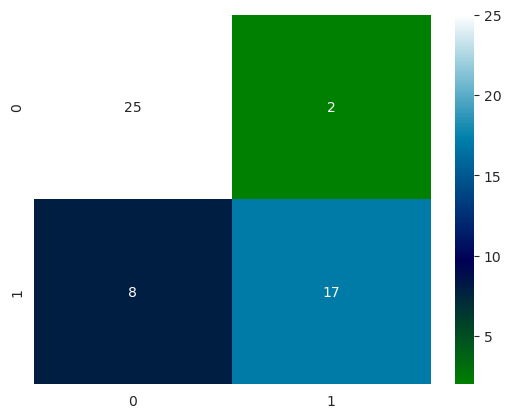

In [86]:
seaborn.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True, cmap='ocean')

In [87]:
# Architecture of my model

model_with_drop = keras.Sequential(
    [
        keras.layers.Dense(60, input_dim=60, activation='relu'),

        keras.layers.Dropout(0.5), # Dropout

        keras.layers.Dense(30, activation='relu'),

        keras.layers.Dropout(0.5),  # Dropout

        keras.layers.Dense(15, activation='relu'),
        # Dropout
        keras.layers.Dropout(0.5),

        keras.layers.Dense(1, activation='sigmoid'),
    ]
)


model_with_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_with_drop.fit(X_train, y_train, epochs=100, batch_size=8)

Epoch 1/100
20/20 [==============================] - 1s 5ms/step - loss: 0.7462 - accuracy: 0.5769
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7273 - accuracy: 0.5769
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.7355 - accuracy: 0.5321
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5833
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.5256
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5256
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.5256
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.5577
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5321
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.5513
Epoch 11/

On the Train set the accuracy here is less than the accuracy of model_no_drop

In [88]:
model_with_drop.evaluate(X_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 0.3969 - accuracy: 0.7692


[0.3969223201274872, 0.7692307829856873]

Most of the time we will have better accuracy with dropout layers on Test dataset.<br> The Accuracy improved.

In [90]:
y_pred_with_drop = model_with_drop.predict(X_test).reshape(-1)
print(f'old y_pred_with_drop: \n {y_pred_with_drop[:5]}')
y_pred_with_drop = np.round(y_pred_with_drop) # round makes our prediction close to his original form which is or 0 or 1
print("------------\nnew y_pred_with_drop:")
y_pred_with_drop

print(classification_report(y_test, y_pred_with_drop))

2/2 [==============================] - 0s 2ms/step
old y_pred_with_drop: 
 [1.2969624e-04 7.6408452e-01 9.2411840e-01 1.1391829e-02 9.9590129e-01]
------------
new y_pred_with_drop:
              precision    recall  f1-score   support

       False       0.74      0.85      0.79        27
        True       0.81      0.68      0.74        25

    accuracy                           0.77        52
   macro avg       0.78      0.77      0.77        52
weighted avg       0.77      0.77      0.77        52


<Axes: >

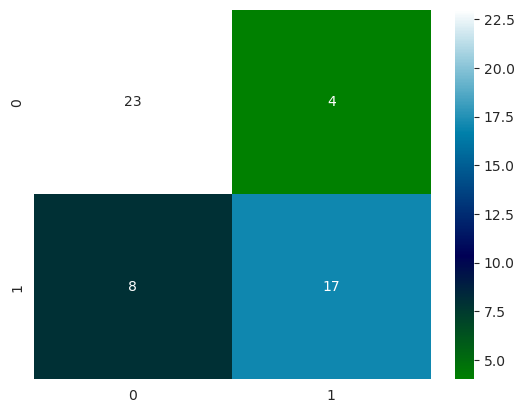

In [91]:
seaborn.heatmap(confusion_matrix(y_test, y_pred_with_drop), annot=True, cmap='ocean')